# How to extract ERA-5 reanalysis data over a defines position or ROI?

ERA5 data archive: https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Instantaneousparameters

# imports

## python module import

In [47]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

from shapely.geometry.polygon import LinearRing
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from skimage.draw import polygon as skpolygon

import json

import cdsapi
c = cdsapi.Client()

## functions

In [48]:


def find_nearest(lons,lats,xlon,xlat):
    dist=( (lats-xlat)**2 +(lons-xlon)**2 )
    sidx=np.unravel_index(dist.argmin(),dist.shape) 
    return sidx,dist[sidx[0],sidx[1]]

def use_polygon(lons,lats,polygon):
    '''
    lons: 2d field of longitudes (e.g. from satellite swath or np.meshgrid(lon,lat))
    lats: 2d field of latitudes  (see above)
    poly: array [[lon0,lat0],[lon1,lat1],...], at least three corner points
    '''
    polg=[]
    for p in polygon:
        polg.append(find_nearest(lons,lats,p[0],p[1])[0])
    
    polg=np.array(polg)
    mask = np.zeros(lons.shape, dtype=np.uint8)
    r,c = polg[:,0], polg[:,1]
    rr, cc = skpolygon(r, c)
    mask[rr, cc] = 1
    return mask.astype(bool)

In [4]:
#!/usr/bin/env python
import cdsapi
 
c = cdsapi.Client()
 
c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'product_type': 'reanalysis',
        'variable': '2m_temperature',
        'year': [
            '2015', '2016', '2017', '2018', '2019', '2020'
                ] ,
        'month': [
                '01', '02', '03', '04', '05', '06',
                '07', '08', '09', '10', '11', '12'
                ],
        'time': '12:00',
        'format': 'netcdf',                 # Supported format: grib and netcdf. Default: grib
        'area'          : [75, -180, 40, 180], # North, West, South, East.          Default: global
        'grid'          : [1.0, 1.0],       # Latitude/longitude grid.           Default: 0.25 x 0.25
    },
    'era5_monthly_2015-2020_temp2m_NorthOf40SouthOf75deg.nc')         # Output file. Adapt as you wish.

2021-02-26 18:30:39,049 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2021-02-26 18:30:39,311 INFO Request is queued
2021-02-26 18:30:41,874 INFO Request is running
2021-02-26 18:31:11,721 INFO Request is completed
2021-02-26 18:31:11,722 INFO Downloading https://download-0009.copernicus-climate.eu/cache-compute-0009/cache/data5/adaptor.mars.internal-1614360640.43197-4385-32-28ce245a-e793-402a-8628-d5c0baac5031.nc to era5_monthly_2015-2020_temp2m_NorthOf40SouthOf75deg.nc (1.8M)
2021-02-26 18:31:12,373 INFO Download rate 2.7M/s   


Result(content_length=1869172,content_type=application/x-netcdf,location=https://download-0009.copernicus-climate.eu/cache-compute-0009/cache/data5/adaptor.mars.internal-1614360640.43197-4385-32-28ce245a-e793-402a-8628-d5c0baac5031.nc)

In [8]:
### Define Paths to data file
DATA_PATH = "/all_mounts/masp26/SMOS_artic/BennetProjects/ConferencesAndMeetings/2021_02_Permabiogeo/" # "/Users"
INFILE = "era5_monthly_2015-2020_temp2m_NorthOf40SouthOf75deg.nc" # replace with your file

### Read in file
nc_data = nc.Dataset(os.path.join(DATA_PATH, INFILE))
print(nc_data.variables) ## print all variable that are in the nc file

### Read variables
nc_time_var = nc_data.variables['time']
cal = nc_time_var.getncattr('calendar')
date_units = nc_time_var.getncattr('units')
dtime = nc.num2date(nc_time_var[:],date_units,calendar=cal, only_use_cftime_datetimes=False)

nc_t2m_var = nc_data.variables['t2m']

t2m_deg = nc_t2m_var[:,:,:].data-273.15

lat_var = nc_data.variables['latitude'][:]
lon_var = nc_data.variables['longitude'][:]

OrderedDict([('longitude', <class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (360,)
filling on, default _FillValue of 9.969209968386869e+36 used), ('latitude', <class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (36,)
filling on, default _FillValue of 9.969209968386869e+36 used), ('time', <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (72,)
filling on, default _FillValue of -2147483647 used), ('t2m', <class 'netCDF4._netCDF4.Variable'>
int16 t2m(time, latitude, longitude)
    scale_factor: 0.001550212685068973
    add_offset: 268.52888797959497
    _FillValue: -32767
    missing_value: -32767
    units: K
    long_name: 2 metre temperature
unlimited dimens

# Plot entire dataset for t2m for t=0

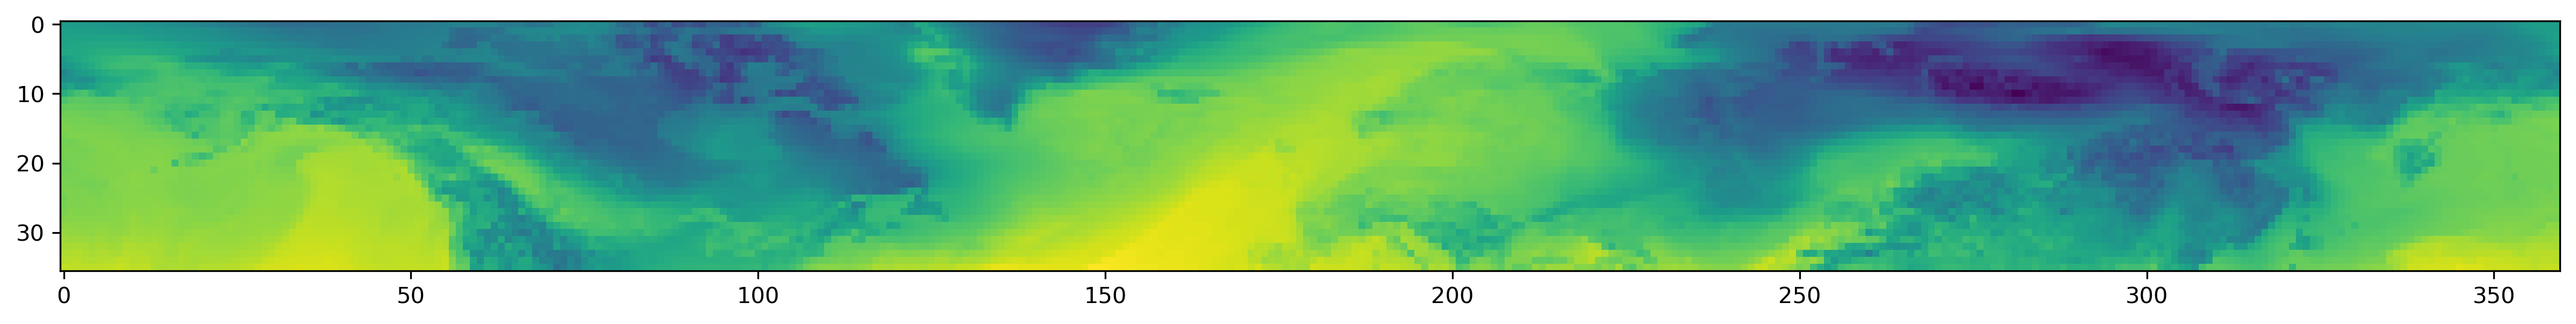

In [45]:
plt.figure(figsize=(20,10), dpi=300)
plt.imshow(t2m_deg[0]);

# Extract data from a coordinate

In [28]:
### Define Lat Lon where you want to extract
LAT = 72.3
LON = 113.73


# change above to match the are of your file
lat_index = np.argmin(np.abs(lat_var - LAT))   
lon_index = np.argmin(np.abs(lon_var - LON))

print("Index of Lat and Lon array: ")
print("lat: ", lat_index, " and ", "Lon: ", lon_index)

Index of Lat and Lon array: 
lat:  3  and  Lon:  294


In [29]:
t2m_deg.shape

### 72 time steps
### 36 lats
### 360 lons

(72, 36, 360)

In [35]:
### iterate through all timesteps and extract the temp data

t2m_for_coordinate = []

for e in t2m_deg[:]:
    t2m_extraction = e[3,294]
    t2m_for_coordinate.append(t2m_extraction)

Text(0, 0.5, 't2m (degC)')

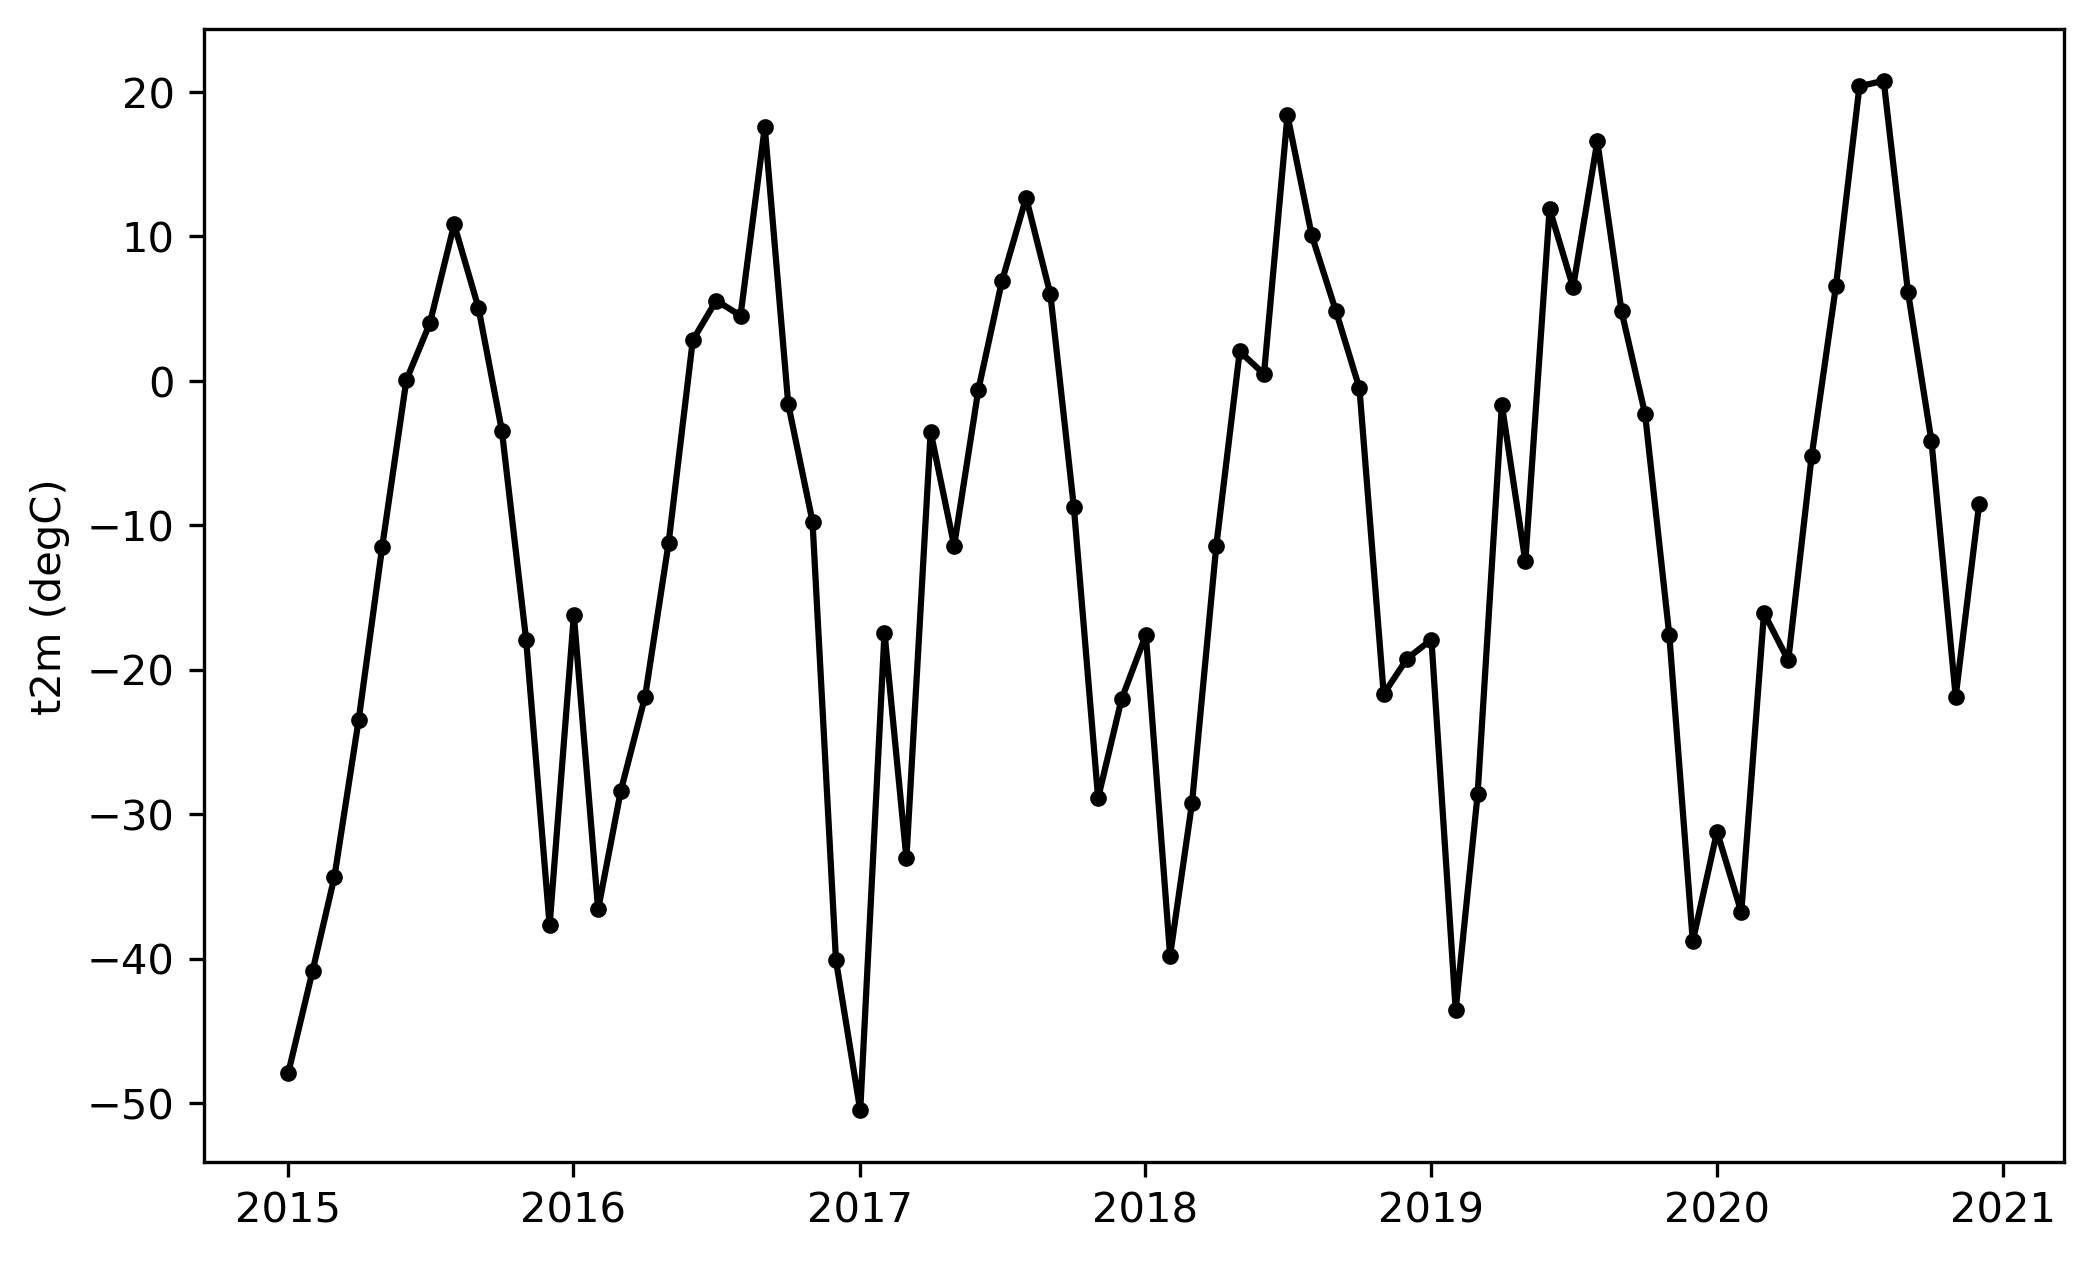

In [44]:
plt.figure(figsize=(8,5), dpi=300)

plt.plot(dtime, t2m_for_coordinate, "k.-")
plt.ylabel("t2m (degC)")

# Extract data for a ROI (Polygon)

In [59]:
####define multipolygon
ROI_polygon = [[119.85525,71.85980],
              [130.89159,71.84359],
              [130.86557,64.29113],
              [120.37562,64.37869]]

lon,lat = np.meshgrid(lon_var,lat_var)
ROI_mask = use_polygon(lon, lat, ROI_polygon)

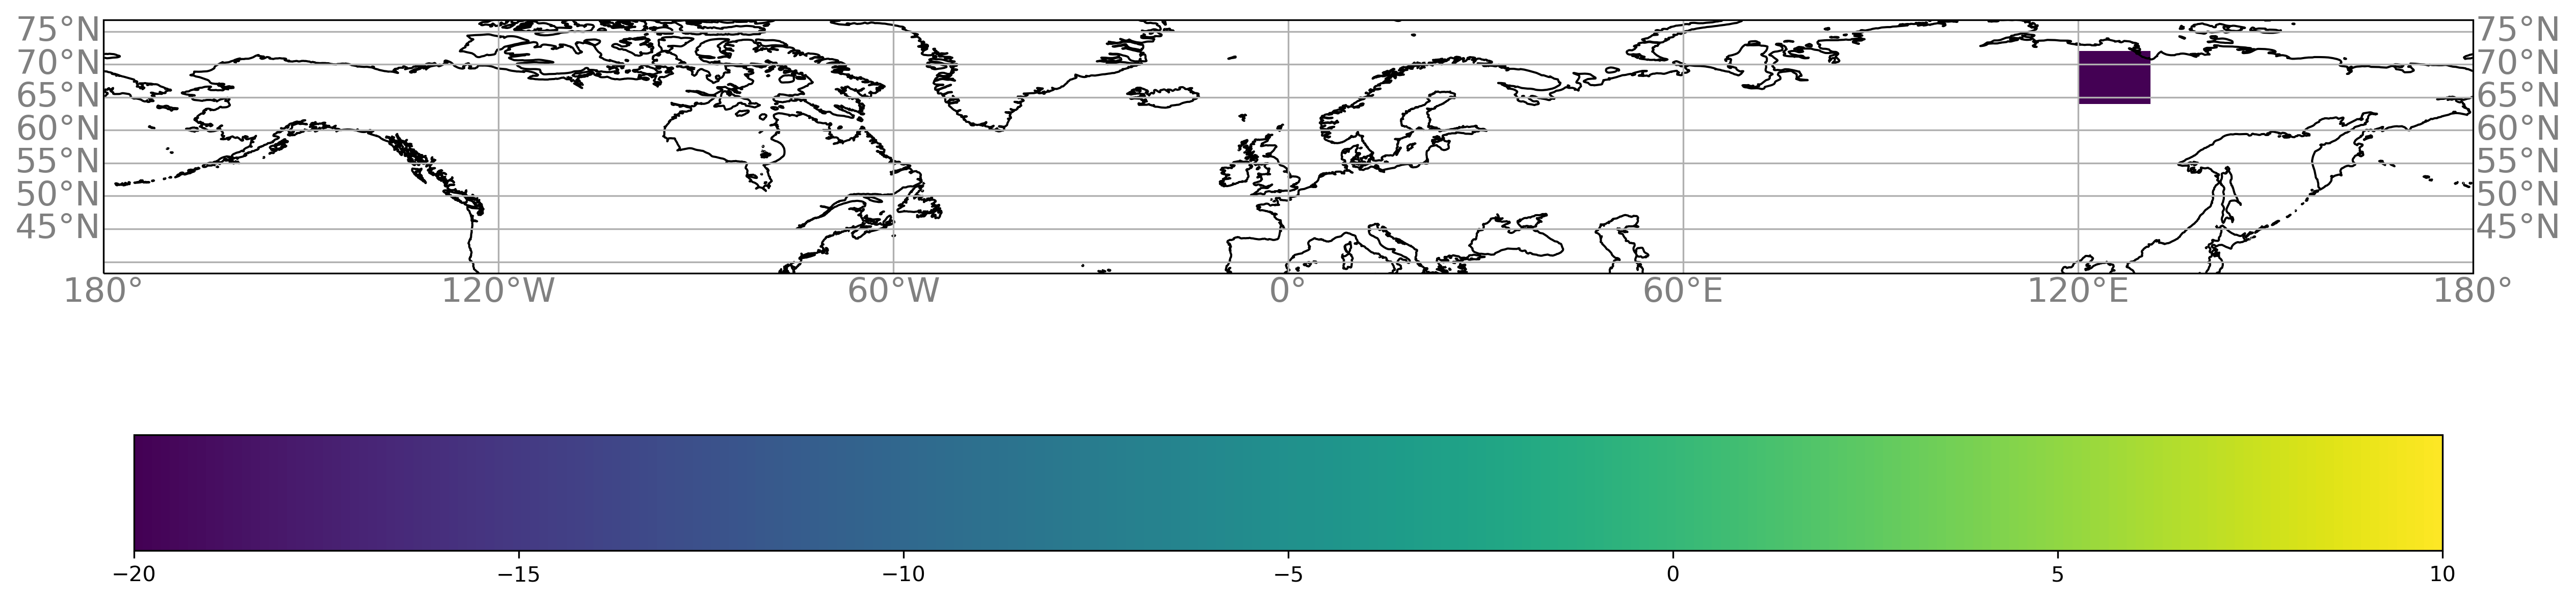

In [60]:
land_resolution = '50m'
fig1 = plt.figure(figsize=(20, 20), dpi=300)

m = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))

f1 = plt.pcolormesh(lon,lat, np.where(ROI_mask, t2m_deg[0], np.nan), shading='flat', 
                    vmin=-20, vmax=10, cmap=plt.cm.viridis)

m.coastlines(resolution=land_resolution, color='black', linewidth=1)

g1 = m.gridlines(draw_labels = True)
g1.xlabels_top = False
g1.xlabel_style = {'size': 16, 'color': 'gray'}
g1.ylabel_style = {'size': 16, 'color': 'gray'}
cbar = plt.colorbar(f1, orientation="horizontal", fraction=0.05, pad=0.07) 

plt.show()

In [61]:
t2m_ROI_mean = []

for e in t2m_deg:
    t2m_extraction = e[ROI_mask]
    t2m_ROI_mean.append(np.nanmean(t2m_extraction))

Text(0, 0.5, 't2m (degC)')

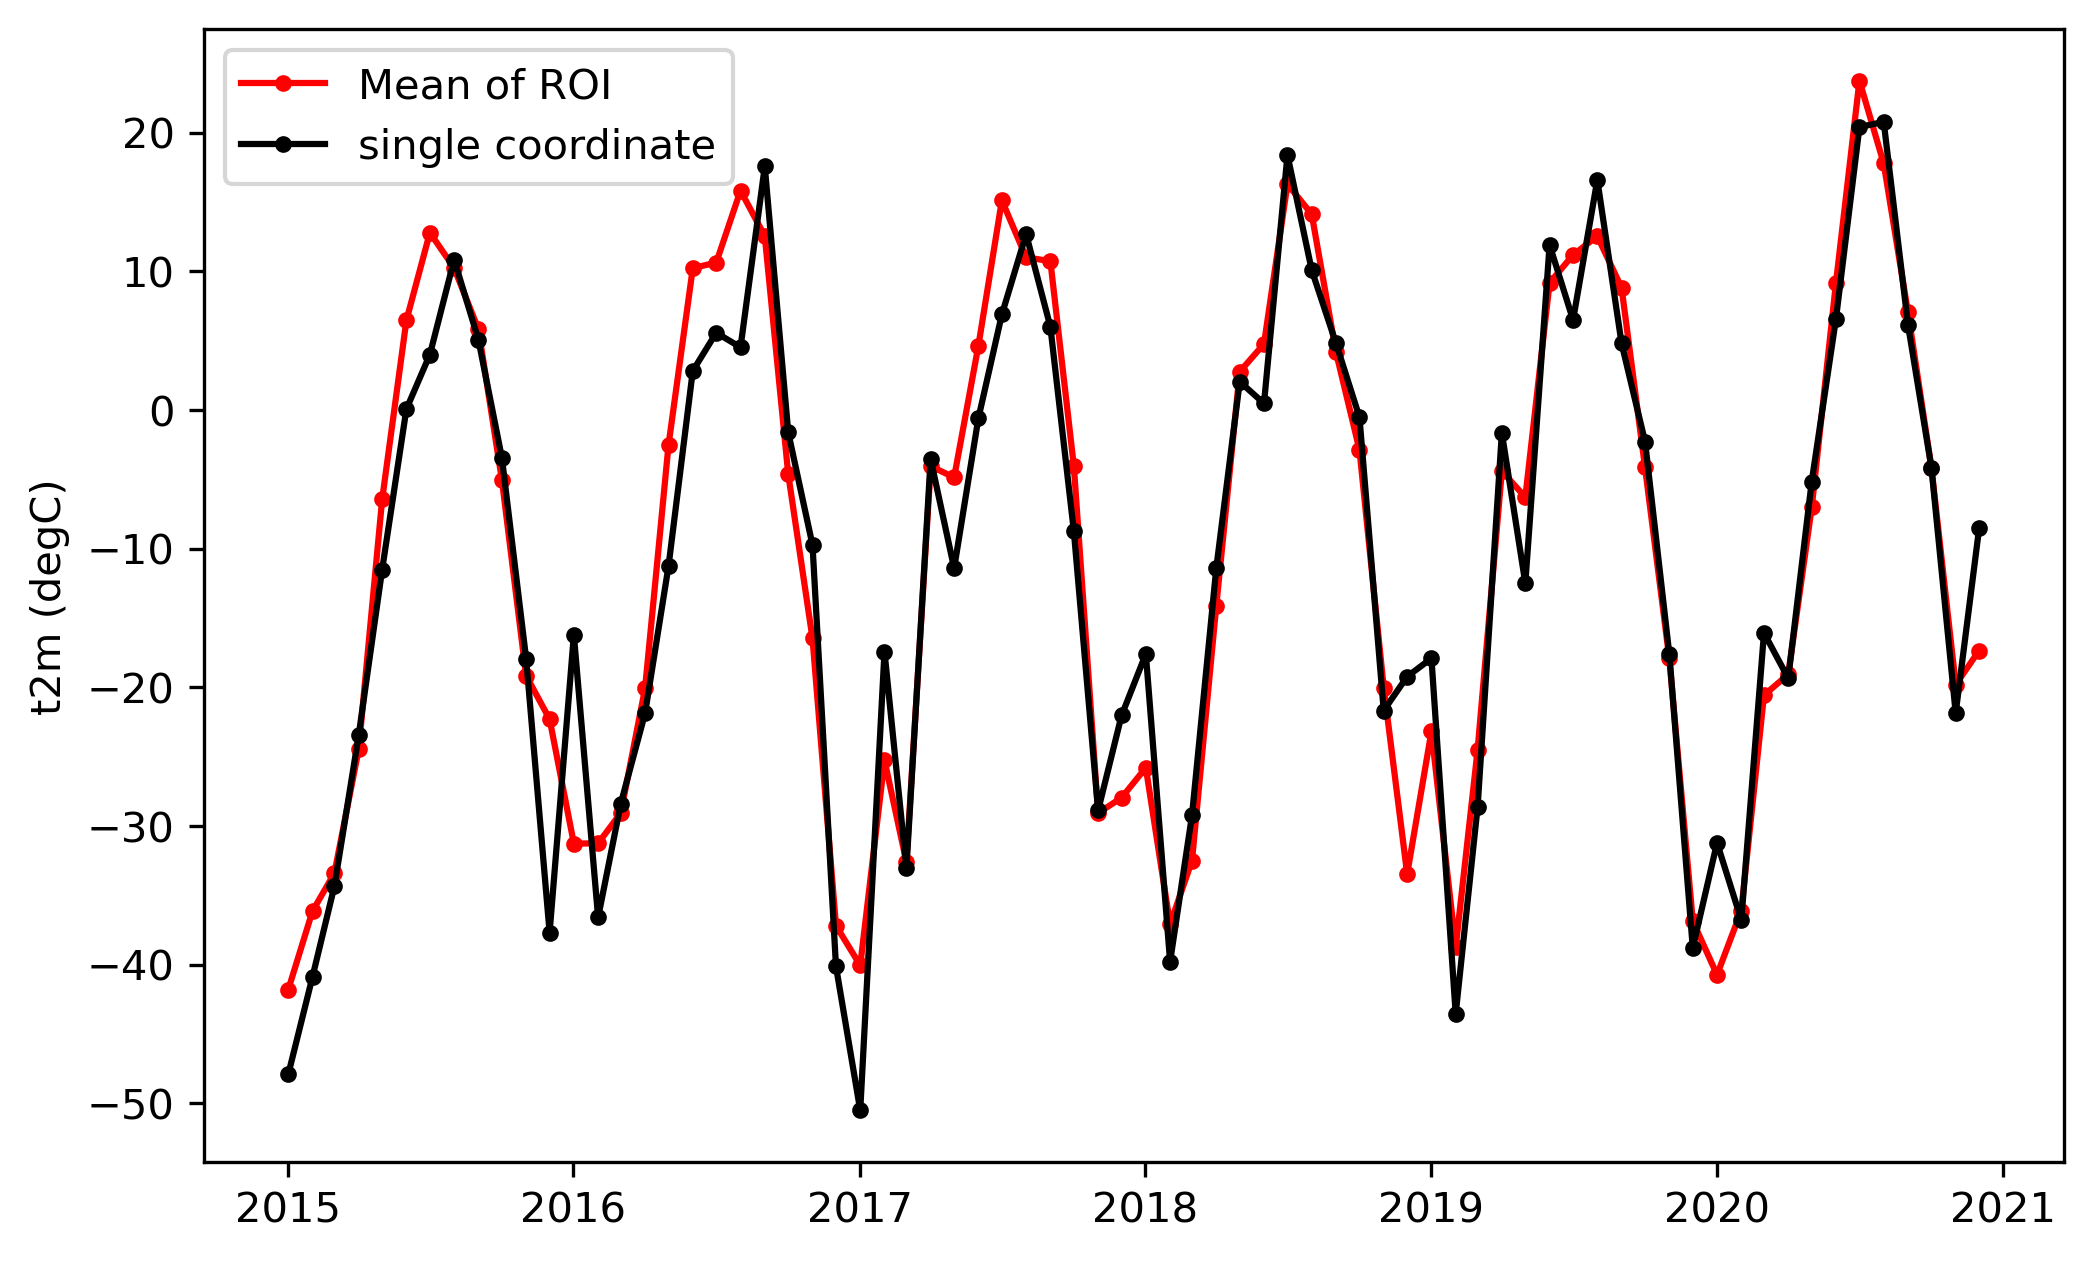

In [68]:
plt.figure(figsize=(8,5), dpi=300)
plt.plot(dtime, t2m_ROI_mean, "r.-", label= "Mean of ROI")
plt.plot(dtime, t2m_for_coordinate, "k.-", label= "single coordinate")

plt.legend()
plt.ylabel("t2m (degC)")

# for non-pythonisti

https://cds.climate.copernicus.eu/#!/home